In [1]:
from bbtnn.tnn_v3 import BBTNN
import scanpy as sc
import pandas as pd
import numpy as np
import bbknn
import warnings
import anndata
warnings.filterwarnings(action = 'ignore')

/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Simulations were performed using the splatter framework (Zappia, Phipson, and Oshlack 2017). For simulation scenario one, 3000 genes and three batches with 2000, 2000 and 3000 cells were simulated using the following parameters: batch.facLoc = 0.5, batch.facScale = 0.3. Additionally, four cell groups with equal probabilities were simulated in each batch. 
Noting that splatter is an R-based package. If you can easily install and successfully run it, you can use the following script to simulate the scRNA data. Otherwise, you can use the simulate dataset in 

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R -o counts -o meta

suppressMessages(library(splatter))

params <- newSplatParams()

params <- setParam(params, "nGenes", 3000)  ## number of genes
params <- setParam(params, "batchCells", c(2000,2000,3000))  ## Number of batches 
params <- setParam(params, "batch.facLoc", 0.5)  ## Location
params <- setParam(params, "batch.facScale", 0.3)   
params <- setParam(params, "group.prob", c(1/4,1/4,1/4,1/4))  ###Group/Class

sim <- splatSimulate(params, method="groups", verbose=FALSE)

counts = data.frame(counts(sim))
meta = data.frame(colData(sim))

In [ ]:
import anndata
adata_all = anndata.AnnData(X=counts.values.T, obs=meta)

In [91]:
adata_all = sc.read('/Users/ywang59/Downloads/simulation_TNN_data.h5')


In [92]:
sc.pp.recipe_zheng17(adata_all)
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all, n_neighbors=15)
sc.tl.umap(adata_all)


In [93]:
adata_all

AnnData object with n_obs × n_vars = 7000 × 1000 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts_all'
    var: 'n_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [94]:
adata= adata_all.copy()

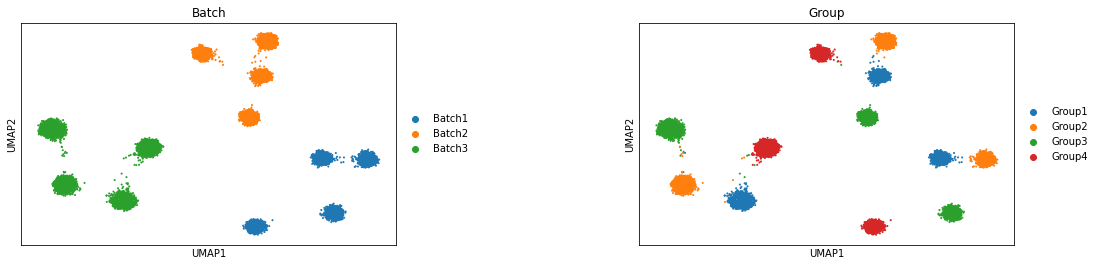

In [95]:
sc.pl.umap(adata_all, color=['Batch','Group'], wspace = 0.5)

In [96]:
adata = adata_all

## Unsupervised model

In [97]:
%%time
bbtnn = BBTNN(k=50, distance='pn', batch_size=128, n_epochs_without_progress=10)
bbtnn.fit(X = adata, Y = None, batch_name='Batch')


version 02.04. 21:30
Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)
3295 cells defined as MNNs
Calculating KNNs...
1977 cells defined as KNNs
Total cells for training:4338
Reorder
Training neural network
Epoch 1/1000
34/34 [==============================] - 4s 132ms/step - loss: 1.6802
Epoch 2/1000
34/34 [==============================] - 0s 10ms/step - loss: 1.3690
Epoch 3/1000
34/34 [==============================] - 0s 9ms/step - loss: 1.2000
Epoch 4/1000
34/34 [==============================] - 0s 9ms/step - loss: 1.1378
Epoch 5/1000
34/34 [==============================] - 0s 9ms/step - loss: 1.0695
Epoch 6/1000
34/34 [==============================] - 0s 9ms/step - loss: 1.0381
Epoch 7/1000
34/34 [==============================] - 0s 9ms/step - loss: 1.0140
Epoch 8/1000
34/34 [==============================] - 0s 9ms/step - loss: 0.9644
Epoch 9/1000
34/34 [==============================] - 0s 9ms/step - loss: 0.9220
Epoch 10/1

34/34 [==============================] - 0s 10ms/step - loss: 0.3586
Epoch 98/1000
34/34 [==============================] - 0s 10ms/step - loss: 0.3686
Epoch 99/1000
34/34 [==============================] - 0s 10ms/step - loss: 0.3768
Epoch 100/1000
34/34 [==============================] - 0s 9ms/step - loss: 0.3570
Epoch 101/1000
34/34 [==============================] - 0s 9ms/step - loss: 0.3596
Epoch 102/1000
34/34 [==============================] - 0s 9ms/step - loss: 0.3731
Epoch 103/1000
34/34 [==============================] - 0s 9ms/step - loss: 0.3732
Epoch 104/1000
34/34 [==============================] - 0s 9ms/step - loss: 0.3437
Epoch 105/1000
34/34 [==============================] - 0s 9ms/step - loss: 0.3523
Epoch 106/1000
34/34 [==============================] - 0s 10ms/step - loss: 0.3686
Epoch 107/1000
34/34 [==============================] - 0s 9ms/step - loss: 0.3726
Epoch 108/1000
34/34 [==============================] - 0s 9ms/step - loss: 0.3512
Epoch 109/1000
34

7000/7000 [==============================] - 2s 231us/sample


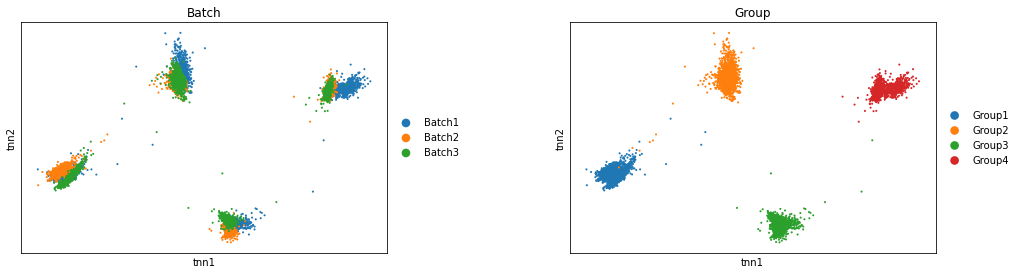

In [98]:
embeddings = bbtnn.transform(adata)
adata.obsm['X_tnn'] = embeddings
sc.pl.scatter(adata, basis='tnn', color=['Batch','Group'], )


In [99]:
%%time
bbtnn = BBTNN(k=50, distance='pn', batch_size=128, n_epochs_without_progress=10 )
bbtnn.fit(X = adata, Y = None, batch_name='Batch', cell_labeled=True, celltype_name = 'Group')


version 02.04. 21:30
Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)
3289 cells defined as MNNs
Generating supervised positive pairs...
[Batch1, Batch2, Batch3]
Categories (3, object): [Batch1, Batch2, Batch3]
3
Processing positive pairs (0, 1)
Processing positive pairs (0, 2)
Processing positive pairs (1, 2)
3200 cells defined as supervision triplets
1571
Calculating KNNs...
1973 cells defined as KNNs
Total cells for training:5658
Reorder
Training neural network
Epoch 1/1000
45/45 [==============================] - 5s 109ms/step - loss: 1.6844
Epoch 2/1000
45/45 [==============================] - 0s 9ms/step - loss: 1.3610
Epoch 3/1000
45/45 [==============================] - 0s 9ms/step - loss: 1.2078
Epoch 4/1000
45/45 [==============================] - 0s 10ms/step - loss: 1.1643
Epoch 5/1000
45/45 [==============================] - 0s 11ms/step - loss: 1.1397
Epoch 6/1000
45/45 [==============================] - 0s 9ms/step - lo

7000/7000 [==============================] - 2s 244us/sample


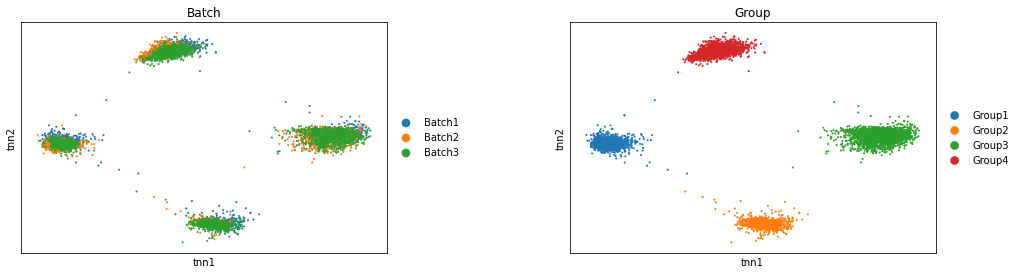

In [100]:
embeddings = bbtnn.transform(adata)
adata.obsm['X_tnn'] = embeddings
sc.pl.scatter(adata, basis='tnn', color=['Batch','Group'], )

## Specific cluster

In [101]:
adata=adata_all

adata = adata[((adata.obs['Batch'].isin(['Batch1','Batch2', 'Batch3'])) & (adata.obs['Group']!='Group4')) | (adata.obs['Batch']=='Batch3')]



In [102]:
adata.obs['Batch'].unique()

[Batch1, Batch2, Batch3]
Categories (3, object): [Batch1, Batch2, Batch3]

In [103]:
%%time
bbtnn = BBTNN(k=50, distance='pn', batch_size=128, n_epochs_without_progress=10)
bbtnn.fit(X = adata, Y = None, batch_name='Batch')


version 02.04. 21:30
Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)
2620 cells defined as MNNs
Calculating KNNs...
1572 cells defined as KNNs
Total cells for training:3513
Reorder
Training neural network
Epoch 1/1000
28/28 [==============================] - 5s 167ms/step - loss: 1.6204
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 1.3540
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 1.2321
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 1.1470
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 1.1060
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 1.0544
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.9898
Epoch 8/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.9706
Epoch 9/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.9199
Epo

6046/6046 [==============================] - 2s 282us/sample


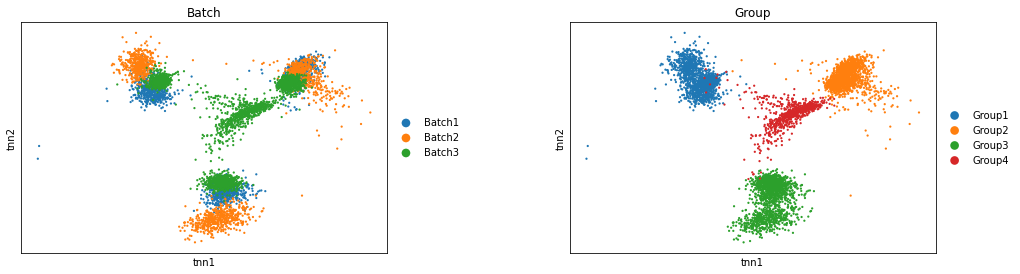

In [104]:
embeddings = bbtnn.transform(adata)
adata.obsm['X_tnn'] = embeddings
sc.pl.scatter(adata, basis='tnn', color=['Batch','Group'], )


In [105]:
%%time
bbtnn = BBTNN(k=50, distance='pn', batch_size=128, n_epochs_without_progress=10 )
bbtnn.fit(X = adata, Y = None, batch_name='Batch', cell_labeled=True, celltype_name = 'Group')


version 02.04. 21:30
Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)
2615 cells defined as MNNs
Generating supervised positive pairs...
[Batch1, Batch2, Batch3]
Categories (3, object): [Batch1, Batch2, Batch3]
3
Processing positive pairs (0, 1)
Processing positive pairs (0, 2)
Processing positive pairs (1, 2)
2437 cells defined as supervision triplets
1212
Calculating KNNs...
1569 cells defined as KNNs
Total cells for training:4577
Reorder
Training neural network
Epoch 1/1000
36/36 [==============================] - 5s 135ms/step - loss: 1.7010
Epoch 2/1000
36/36 [==============================] - 0s 9ms/step - loss: 1.3464
Epoch 3/1000
36/36 [==============================] - 0s 9ms/step - loss: 1.2023
Epoch 4/1000
36/36 [==============================] - 0s 9ms/step - loss: 1.1584
Epoch 5/1000
36/36 [==============================] - 0s 9ms/step - loss: 1.1294
Epoch 6/1000
36/36 [==============================] - 0s 9ms/step - loss

36/36 [==============================] - 0s 9ms/step - loss: 0.4109
Epoch 95/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.4212
Epoch 96/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.4257
Epoch 97/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.4247
Epoch 98/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.4080
Epoch 99/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.4190
Epoch 100/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.4130
Epoch 101/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.4122
Epoch 102/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.4260
Epoch 103/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.4157
CPU times: user 50.3 s, sys: 10.3 s, total: 1min
Wall time: 41.5 s


6046/6046 [==============================] - 2s 290us/sample


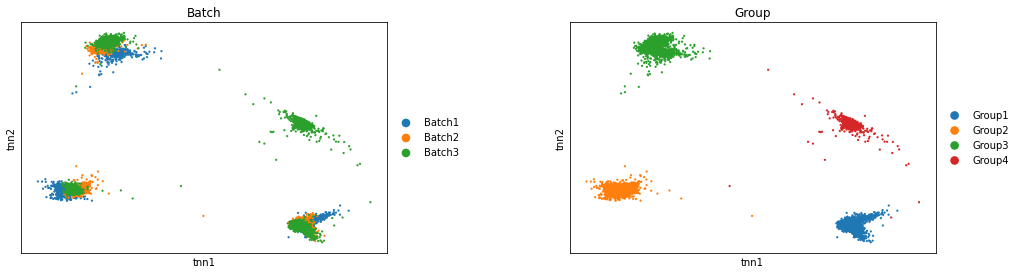

In [106]:
embeddings = bbtnn.transform(adata)
adata.obsm['X_tnn'] = embeddings
sc.pl.scatter(adata, basis='tnn', color=['Batch','Group'], )
